In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
#Inspector Returns:
#measurement
#id INTEGER
#station TEXT
#date TEXT
#prcp FLOAT
#tobs FLOAT

#station
#id INTEGER
#station TEXT
#name TEXT
#latitude FLOAT
#longitude FLOAT
#elevation FLOAT

# Exploratory Climate Analysis

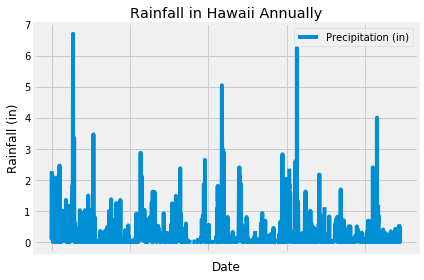

In [37]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
finaldate = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#finaldate = '08-23-2017'

# Calculate the date 1 year ago from the last data point in the database
lastyear = dt.date(2017, 8, 23) - dt.timedelta(days=365)
#lastyear = 08-23-2016

# Perform a query to retrieve the data and precipitation scores
rainydays = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > lastyear).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
rainydays_df = pd.DataFrame(rainydays)

# Sort the dataframe by date
rainydays_df.set_index('date')

# Use Pandas Plotting with Matplotlib to plot the data
rainydays_df.plot ('date','prcp')

plt.xlabel("Date")
plt.ylabel("Rainfall (in)")

plt.title("Rainfall in Hawaii Annually")
plt.legend(["Precipitation (in)"])

plt.tight_layout()
plt.show()

![precipitation](Images/precipitation.png)

In [38]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rainydays_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [39]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Measurement.station).distinct().count()
stations

9

In [40]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stationactivity = session.query(Measurement.station, func.count(Measurement.tobs)).\
                                group_by(Measurement.station).\
                                order_by(func.count(Measurement.tobs).desc()).all()
stationactivity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [43]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
#tempmax = session.query(Measurement.station, func.max(Measurement.tobs)). filter(Measurement.station == "USC00519281")
#tempmin = session.query(Measurement.station, func.min(Measurement.tobs)). filter(Measurement.station == "USC00519281")
#avgtemp = session.query(Measurement.station, func.average(Measurement.tobs)). filter(Measurement.station == "USC00519281")

busybodies = session.query(Measurement.station, Measurement.date, Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date > lastyear).\
    order_by(Measurement.date).all()


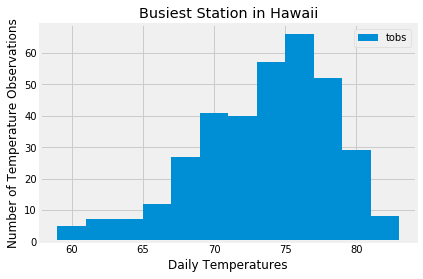

In [48]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
busybodies_df=pd.DataFrame(busybodies)

plt.hist(temp_df['tobs'],12)

plt.xlabel("Daily Temperatures")
plt.ylabel("Number of Temperature Observations")
plt.title("Busiest Station in Hawaii")

plt.legend(["tobs"])
plt.show()

![precipitation](Images/station-histogram.png)

In [49]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [50]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
arrival = dt.date(2016, 12, 24)
departure = dt.date(2016, 12, 31)
historic = dt.timedelta(days=365)

daysgoneby = (calc_temps((arrival - historic), (departure - historic)))

print(daysgoneby)


[(62.0, 72.11111111111111, 79.0)]


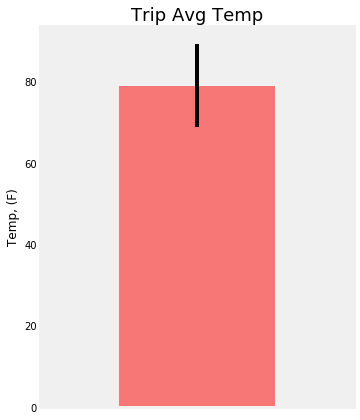

In [51]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
vacay_df = pd.DataFrame(daysgoneby, columns=['Low Temperature', 'High Temperature', 'Average Temperature'])
avgtemp = vacay_df['Average Temperature']
peaktopeak = vacay_df.iloc[0]['High Temperature'] - vacay_df.iloc[0]['Low Temperature']

avgtemp.plot(kind='bar', yerr=peaktopeak, figsize=(5,7), alpha=0.5, color='red')
plt.title("Trip Avg Temp", fontsize=18)
plt.ylabel("Temp, (F)")
plt.xticks([])

plt.grid()
plt.show()


In [54]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
monsoonseason = session.query(Station.station, func.sum(Measurement.prcp), 
                              Station.name, Station.elevation, Station.latitude, Station.longitude)\
.filter(Measurement.station == Station.station).filter(Measurement.date >= historic)\
.filter(Measurement.date <= historic).group_by(Station.station).order_by(func.sum(Measurement.prcp).desc())
monsoonseason


## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
